In [9]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


In [10]:
# Constants
MAX_EPISODES = int(1e6)
NUM_RUNS = 10
ACTIONS = ['left', 'right']
GAMMA = 1.0  # Discount factor
OIS_COLOR = 'blue'
WIS_COLOR = 'red'


In [11]:
class OneStateMDPEnvironment:
    """Environment for the one-state MDP used in Example 5.5."""

    def __init__(self):
        """Initializes the environment."""
        self.state = 's'
        self.is_terminal = False

    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
            str: The initial state.
        """
        self.state = 's'
        self.is_terminal = False
        return self.state

    def step(self, action):
        """
        Takes an action and returns next_state, reward, done.

        Args:
            action (str): The action taken ('left' or 'right').

        Returns:
            tuple:
                - next_state (str): The next state.
                - reward (float): The reward received.
                - done (bool): True if the next state is terminal.
        """
        if self.state == 's':
            if action == 'left':
                # With probability 0.9, stay in 's', reward 0
                # With probability 0.1, go to terminal state, reward +1
                if np.random.rand() < 0.9:
                    next_state = 's'
                    reward = 0.0
                    done = False
                else:
                    next_state = 'terminal'
                    reward = 1.0
                    done = True
            elif action == 'right':
                # Transition to terminal state, reward 0
                next_state = 'terminal'
                reward = 0.0
                done = True
            else:
                raise ValueError("Invalid action")
            self.state = next_state
            self.is_terminal = done
            return next_state, reward, done
        else:
            raise ValueError("Cannot take action from terminal state")
        

In [12]:
class Agent:
    """Agent that follows the behavior and target policies."""

    def __init__(self):
        """Initializes the agent with available actions."""
        self.actions = ACTIONS

    def behavior_policy(self):
        """
        Selects an action according to the behavior policy.

        Returns:
            str: The selected action.
        """
        return np.random.choice(self.actions)

    def get_behavior_prob(self, state, action):
        """
        Computes the probability of an action under the behavior policy.

        Args:
            state (str): The current state.
            action (str): The action to compute the probability for.

        Returns:
            float: The probability of taking the action under the behavior policy.
        """
        if action in self.actions:
            return 1.0 / len(self.actions)
        else:
            return 0.0

    def target_policy(self):
        """
        Selects an action according to the target policy.

        Returns:
            str: The selected action ('left').
        """
        return 'left'

    def get_target_prob(self, state, action):
        """
        Computes the probability of an action under the target policy.

        Args:
            state (str): The current state.
            action (str): The action to compute the probability for.

        Returns:
            float: The probability of taking the action under the target policy.
        """
        if action == 'left':
            return 1.0
        else:
            return 0.0


In [13]:
def run_episode(env, agent):
    """
    Runs an episode using the behavior policy.

    Args:
        env (OneStateMDPEnvironment): The environment instance.
        agent (Agent): The agent instance.

    Returns:
        tuple:
            - episode (list): List of (state, action, reward) tuples.
            - rho (float): The importance sampling ratio for the episode.
            - G (float): The return (total discounted reward) from the episode.
    """
    episode = []
    state = env.reset()
    done = False
    rho = 1.0
    while not done:
        action = agent.behavior_policy()
        pi = agent.get_target_prob(state, action)
        b = agent.get_behavior_prob(state, action)
        rho *= (pi / b)

        next_state, reward, done = env.step(action)
        episode.append((state, action, reward))
        state = next_state

        # If the importance sampling ratio becomes zero, we can stop accumulating
        if rho == 0.0:
            break

    # Calculate the return G (since gamma=1, it's the sum of rewards)
    G = sum([step[2] for step in episode])
    return episode, rho, G


In [14]:

def off_policy_mc_prediction(env, agent, num_episodes, method, episode_counts):
    """
    Performs off-policy MC prediction using importance sampling.

    Args:
        env (OneStateMDPEnvironment): The environment instance.
        agent (Agent): The agent instance.
        num_episodes (int): Number of episodes to run.
        method (str): 'ordinary' or 'weighted' importance sampling method.
        episode_counts (array): Episodes at which to record estimates.

    Returns:
        list: The estimates of V(s) at specified episodes.
    """
    estimates = []
    cumulative_sum = 0.0
    cumulative_weight = 0.0

    idx = 0  # Index for episode_counts

    for episode_num in range(1, num_episodes + 1):
        episode, rho, G = run_episode(env, agent)

        # Update estimates based on the chosen importance sampling method
        if method == 'ordinary':
            cumulative_sum += rho * G
            estimate = cumulative_sum / episode_num
        elif method == 'weighted':
            cumulative_sum += rho * G
            cumulative_weight += rho
            if cumulative_weight == 0:
                estimate = 0.0
            else:
                estimate = cumulative_sum / cumulative_weight
        else:
            raise ValueError("Invalid method. Choose 'ordinary' or 'weighted'.")

        # Record estimates at specified episodes for plotting
        if episode_num == episode_counts[idx]:
            estimates.append(estimate)
            if idx < len(episode_counts) - 1:
                idx += 1

        # If all required estimates are collected, break early
        if idx >= len(episode_counts):
            break

    return estimates


In [15]:
def run_single_simulation(method, episode_counts):
    """
    Runs a single simulation for the given importance sampling method.

    Args:
        method (str): 'ordinary' or 'weighted' importance sampling method.
        episode_counts (array): Episodes at which to record estimates.

    Returns:
        list: The estimates of V(s) at specified episodes.
    """
    env = OneStateMDPEnvironment()
    agent = Agent()
    estimates = off_policy_mc_prediction(
        env, agent, MAX_EPISODES, method=method, episode_counts=episode_counts)
    return estimates


Starting OIS runs...
Completed all OIS runs.
Starting WIS runs...
Completed all WIS runs.


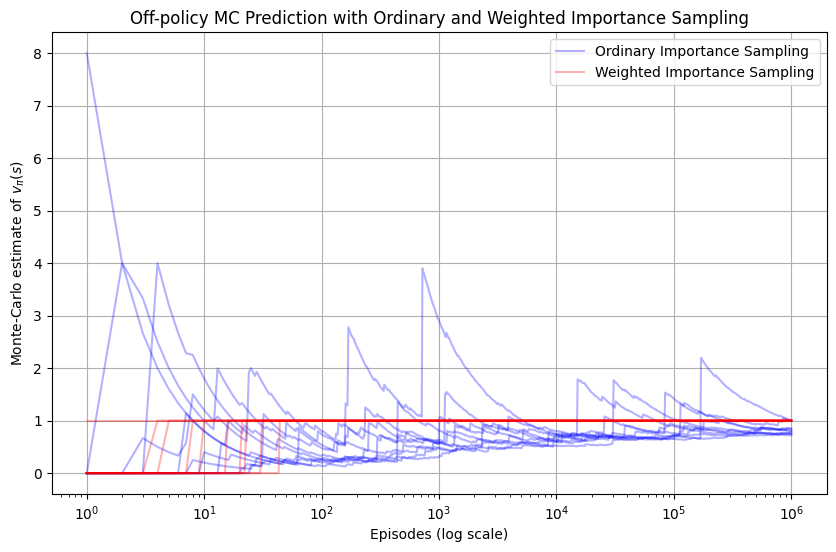

In [16]:
def main():
    """Main function to run simulations and plot the results."""
    # Define episode counts for plotting (logarithmically spaced)
    episode_counts = np.unique(
        np.logspace(0, np.log10(MAX_EPISODES), num=1000).astype(int))

    # Run simulations for ordinary importance sampling in parallel
    print("Starting OIS runs...")
    estimates_ordinary = Parallel(n_jobs=-1)(
        delayed(run_single_simulation)('ordinary', episode_counts)
        for _ in range(NUM_RUNS)
    )
    print("Completed all OIS runs.")

    # Run simulations for weighted importance sampling in parallel
    print("Starting WIS runs...")
    estimates_weighted = Parallel(n_jobs=-1)(
        delayed(run_single_simulation)('weighted', episode_counts)
        for _ in range(NUM_RUNS)
    )
    print("Completed all WIS runs.")

    # Plotting the results
    plt.figure(figsize=(10, 6))

    # Plot estimates for ordinary importance sampling
    for idx, estimates in enumerate(estimates_ordinary):
        if idx == 0:
            plt.plot(episode_counts, estimates, color=OIS_COLOR, alpha=0.3,
                     label='Ordinary Importance Sampling')
        else:
            plt.plot(episode_counts, estimates, color=OIS_COLOR, alpha=0.3)

    # Plot estimates for weighted importance sampling
    for idx, estimates in enumerate(estimates_weighted):
        if idx == 0:
            plt.plot(episode_counts, estimates, color=WIS_COLOR, alpha=0.3,
                     label='Weighted Importance Sampling')
        else:
            plt.plot(episode_counts, estimates, color=WIS_COLOR, alpha=0.3)

    # Configure plot settings
    plt.xscale('log')
    plt.xlabel('Episodes (log scale)')
    plt.ylabel('Monte-Carlo estimate of $v_\\pi(s)$')
    plt.title('Off-policy MC Prediction with Ordinary and Weighted Importance Sampling')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()
